# Fake News Detection

This Project is related to detecting whether the news are real (1) or fake (0) using recurrent neural network

Dataset: 

## Importing necessary libraries and dataset

In [1]:
import nltk
nltk.download('punkt')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Piotrek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# Reading dataset
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

## Exploring dataset


In [23]:
df_true.info()
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [15]:
df_true.describe()


title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   

                                                     text       subject  \
count                                               21417         21417   
unique                                              21192             2   
top     (Reuters) - Highlights for U.S. President Dona...  politicsNews   
freq                                                    8         11272   

                      date  
count                21417  
unique                 716  
top     December 20, 2017   
freq                   182

In [24]:
df_fake.describe()

title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46

In [20]:
df_true.isnull().sum()


title      0
text       0
subject    0
date       0
dtype: int64

In [25]:
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

## Feature engineering

In [26]:
df_true['isFake'] = 0
df_true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isFake  
0  December 31, 2017        0  
1  December 29, 2017        0  
2  December 31, 2017        0  
3  December 30, 2017        0  
4  December 29, 2017        0

In [27]:
df_fake['isFake'] = 1
df_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  isFake  
0  December 31, 2017       1  
1  December 31, 2017       1  
2  December 30, 2017       1  
3  December 29, 2017       1  
4  December 25, 2017       1

In [29]:
# Combining both dataset
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isFake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

In [30]:
df.drop(columns = ['date'], inplace=True)

In [32]:
# combining title and text
df['original'] = df['title'] + ' ' + df['text']
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       isFake                                           original  
0           0  As U.S. budget fight looms, Republicans flip t...  
1           0  U.S. military to accept transgender recruits o...  
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...  
3           0  FBI Russia probe helped by Australian diplomat...  
4           0  Trump wants Postal Service to charge 'much mor...  
...       ...                                                ...  
44893       1  McPain: John McCain Furious That Iran Treated ...  
44894       1  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  
44895       1  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  
44896       1  How to Blow $700 Million: Al Jazeera America F...  
44897       1  10 U.S. Navy Sailors Held by Iranian Military ...  

[44898 rows x 5 columns]

## Data Cleaning

In [33]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Piotrek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [34]:
# Obtaining stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

In [36]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
# Removing stopwords from the dataset
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [45]:
df['clean'] = df['original'].apply(preprocess)

In [54]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [55]:
df['clean'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [53]:
# Obtaiining the total words present in the dataset
list_of_words = []
for row in df.clean:
    for word in row:
        list_of_words.append(word)

In [52]:
df.clean[0][0]

'budget'

In [56]:
len(list_of_words)

9276947

In [58]:
# Obtaining the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [60]:
# Combining all words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df.clean_joined

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller washington r...
3        russia probe helped australian diplomat washin...
4        trump wants postal service charge amazon shipm...
                               ...                        
44893    mcpain john mccain furious iran treated sailor...
44894    justice yahoo settles mail privacy class actio...
44895    sunnistan allied safe zone plan territorial bo...
44896    blow million jazeera america finally calls qui...
44897    navy sailors held iranian military signs neoco...
Name: clean_joined, Length: 44898, dtype: object

# Visualizaing dataset

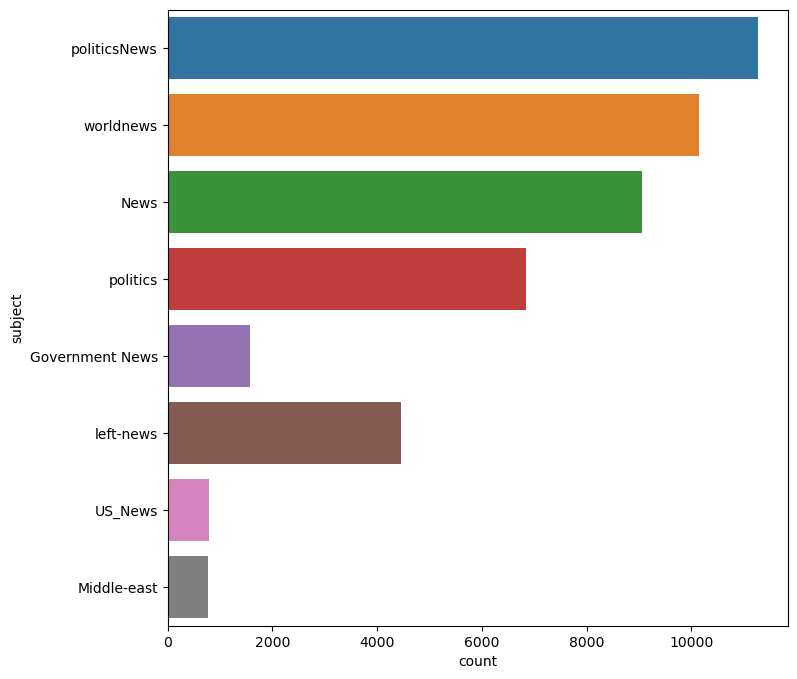

In [63]:
# Plotting the number of sample in 'subject'
plt.figure(figsize= (8,8))
sns.countplot( y = 'subject', data = df)
plt.show()

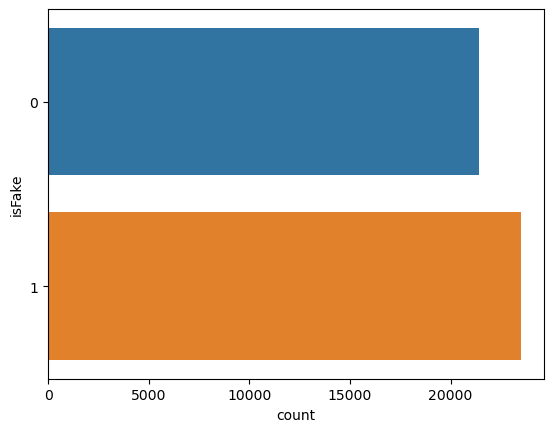

In [66]:
sns.countplot(y = 'isFake',data = df)
plt.show()

In [71]:
# plotting the word cloud for text that is fake
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.isFake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')


In [72]:
# plotting the word cloud for text that is real
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df.isFake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

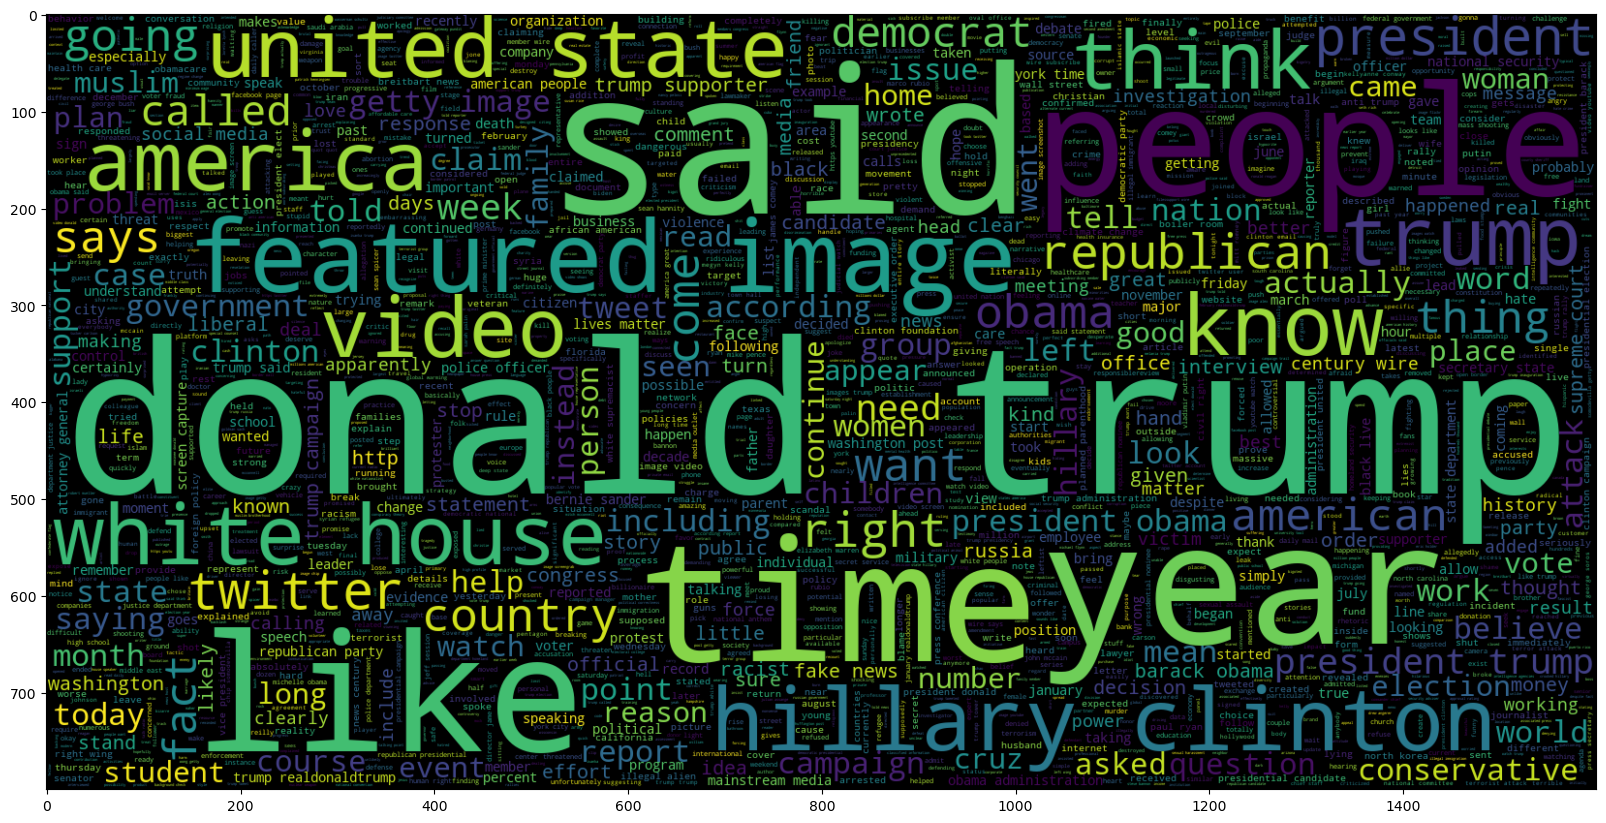

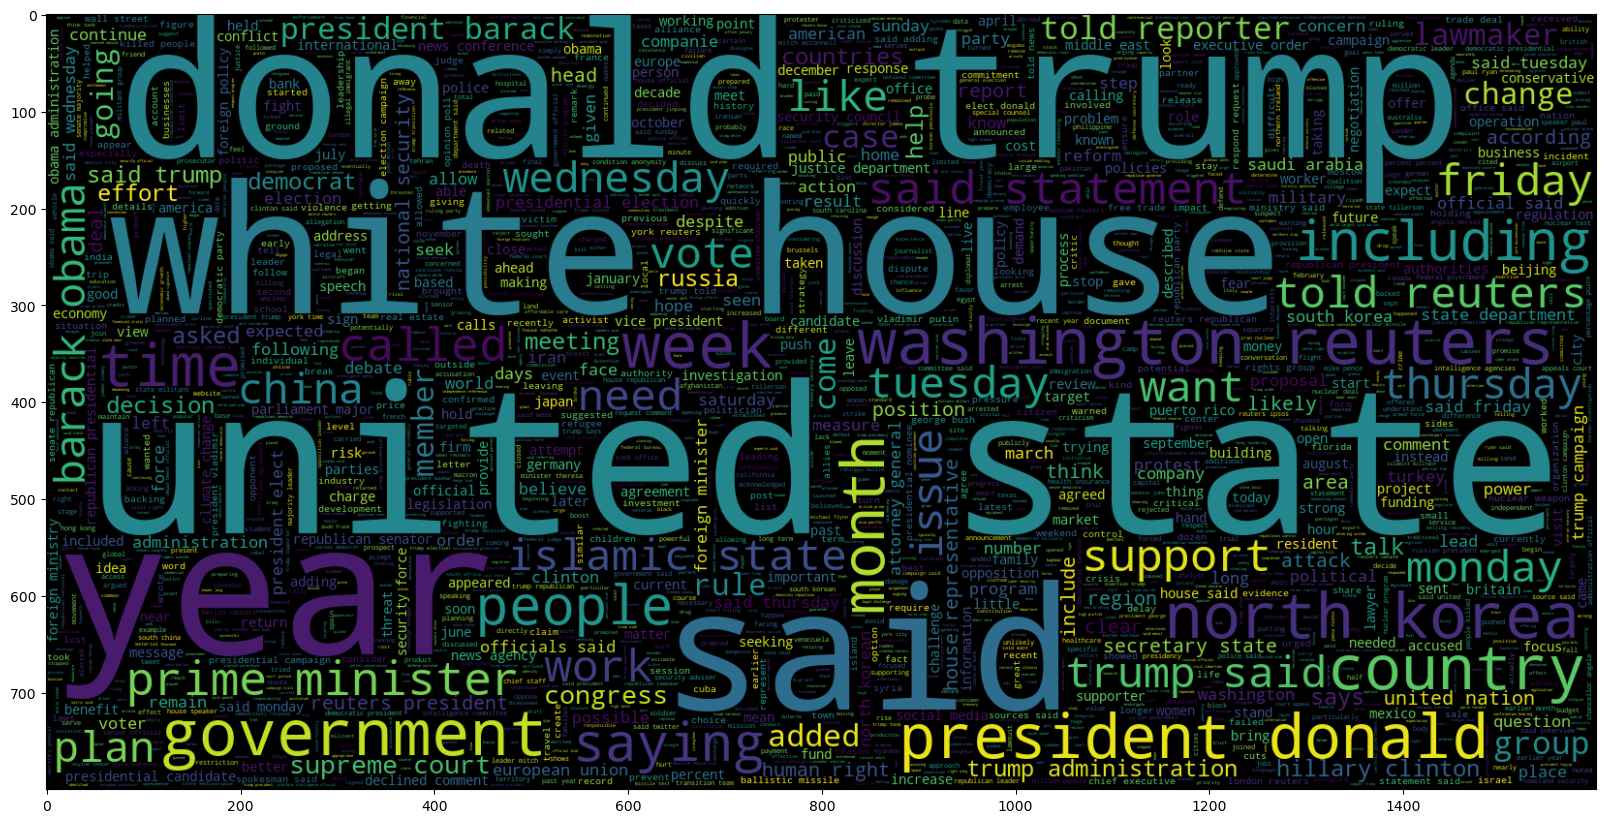

In [73]:
plt.show()

In [74]:
# Getting the longest row
maxlen = -1
for row in df.clean_joined:
    tokens = nltk.word_tokenize(row)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)

print("The maximum number of words in a row is: ", maxlen)

The maximum number of words in a row is:  4405


In [75]:
# Visualizing the distribution of number of words in a text 
import plotly.express as px
fig = px.histogram( x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
x = [print(len(nltk.word_tokenize(x))) for x in df.clean_joined]


383
337
226
206
435
334
278
69
45
47
201
298
48
87
182
240
360
83
239
121
286
464
214
193
387
195
168
125
39
233
99
113
59
179
547
414
268
237
252
53
88
170
306
37
237
212
302
205
47
213
52
471
352
223
227
202
123
93
209
328
247
137
400
188
321
339
701
234
203
77
94
500
38
49
307
419
383
394
195
350
245
217
48
237
70
575
46
243
178
48
36
54
319
184
132
48
187
183
186
285
234
477
51
172
64
110
224
54
555
453
195
57
47
195
293
50
47
356
129
146
169
104
75
159
202
224
217
364
335
149
53
43
42
37
40
278
215
127
385
354
118
237
244
265
226
200
162
395
325
59
50
54
180
48
30
161
119
148
204
52
246
266
466
538
139
224
225
241
50
278
107
257
129
300
192
509
140
39
127
34
41
117
34
93
312
58
418
461
153
54
250
57
80
324
247
56
196
171
166
102
287
326
82
51
76
273
57
53
422
266
361
327
193
279
265
257
350
99
487
204
51
199
519
44
455
268
436
319
223
274
276
464
567
128
315
226
163
84
288
291
170
168
156
391
43
188
459
301
434
218
301
294
311
293
137
238
151
111
228
306
44
299
38
84
322
76
187
21

225
194
350
276
177
322
158
236
294
285
179
191
206
160
190
165
473
275
137
222
126
49
287
178
179
352
196
87
173
268
392
232
215
418
217
426
446
217
121
213
466
466
289
251
196
219
66
146
73
480
97
176
78
151
333
305
108
54
100
45
55
259
56
428
275
43
61
236
315
441
106
81
355
137
129
200
202
210
276
266
124
165
53
39
118
146
57
59
57
343
47
223
257
71
105
310
195
247
227
201
138
332
230
204
399
372
261
223
150
224
228
54
45
226
240
212
348
71
63
188
231
244
233
135
488
204
241
59
199
119
213
78
196
237
209
187
320
63
220
139
59
49
52
184
309
190
311
390
193
51
357
397
353
215
434
257
57
355
25
545
301
245
196
443
106
44
179
67
157
288
44
396
53
243
230
69
66
62
61
277
51
246
45
71
379
198
416
169
40
33
53
230
351
183
239
57
58
426
223
228
223
64
211
286
324
294
41
294
260
337
34
222
165
224
220
44
131
252
71
194
181
67
463
362
631
396
80
66
301
80
207
319
323
208
210
97
67
99
273
52
262
376
497
61
557
284
45
369
55
345
208
58
45
101
42
438
71
192
44
219
230
68
67
449
53
32
65
356
263